# Школа глубокого обучения

<a href="https://mipt.ru/science/labs/laboratoriya-neyronnykh-sistem-i-glubokogo-obucheniya/"><img align="right" src="https://avatars1.githubusercontent.com/u/29918795?v=4&s=200" alt="DeepHackLab" style="position:relative;top:-40px;right:10px;height:100px;" /></a>



### Физтех-Школа Прикладной математики и информатики МФТИ 
### Лаборатория нейронных сетей и глубокого обучения (DeepHackLab)

## Домашнее задание 2
*Щелчков Дмитрий (@demikandr в telegram) *
### Классификация лиц методом ближайших соседей 

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

В этом задании вы обучите очень простую модель для распознавания лиц. С точки зрения машинного обучения это будет задача многоклассовой классификации -- для каждого объекта надо определить к какому классу он принадлежит (чье лицо на фотографии). В качестве метрики качества будем использовать accuracy - долю верно опознанных лиц (верно определенных классов).

В процессе вам потребуется ответить на несколько вопросов и заполнить отчет о проведенных экспериментах. Отчет должен содержать описание того, что вы сделали, и результаты, которые вы получили. Пример: "Я начинал делать домашку за 10,7, 5, 3, 1 и -1 день от дедлайна. Я обнаружил, что максимальная оценка достигается, если начинать делать домашку хотя бы за 5 дней до дедлайна."

### Загрузим данные

In [2]:
import scipy.io

image_h, image_w = 32, 32

data = scipy.io.loadmat('faces_data.mat')

# data - это словарь из четырех матриц: train_faces, train_labels, test_faces, test_labels
#
# Каждый столбец матрицы train_faces является транспонированной картинкой преобразованной
# в одномерный столбец. Получим из этого массив картинок.
# 
# Каждый элемент массива train_labels - это номер класса соответствующего изображения, где
# классы пронумернованы от 1 до 40. Как правило, удобнее нумеровать классы начиная с нуля.

X_train = data['train_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0))
y_train = (data['train_labels'] - 1).reshape((-1,))
X_test = data['test_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0))
y_test = (data['test_labels'] - 1).reshape((-1,))

n_features = X_train.shape[1]
n_train = len(y_train)
n_test = len(y_test)
n_classes = len(np.unique(y_train))

print('Dataset loaded.')
print('  Image size        : {}x{}'.format(image_h, image_w))
print('  Train images      : {}'.format(n_train))
print('  Test images       : {}'.format(n_test))
print('  Number of classes : {}'.format(n_classes))

Dataset loaded.
  Image size        : 32x32
  Train images      : 280
  Test images       : 120
  Number of classes : 40


Посмотрим на лица.

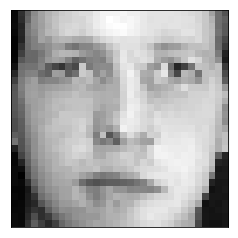

In [4]:
plt.figure()
plt.imshow(X_train[5], cmap=plt.cm.gray)
plt.xticks(()) # Удаляет метки на оси Ox
plt.yticks(()) # Удаляет метки на оси Oy
plt.show()

Чтобы не выводить лица каждый раз голыми руками напишем вспомогательную функцию.

In [5]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Вспомогательная функция для отрисовки лиц"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

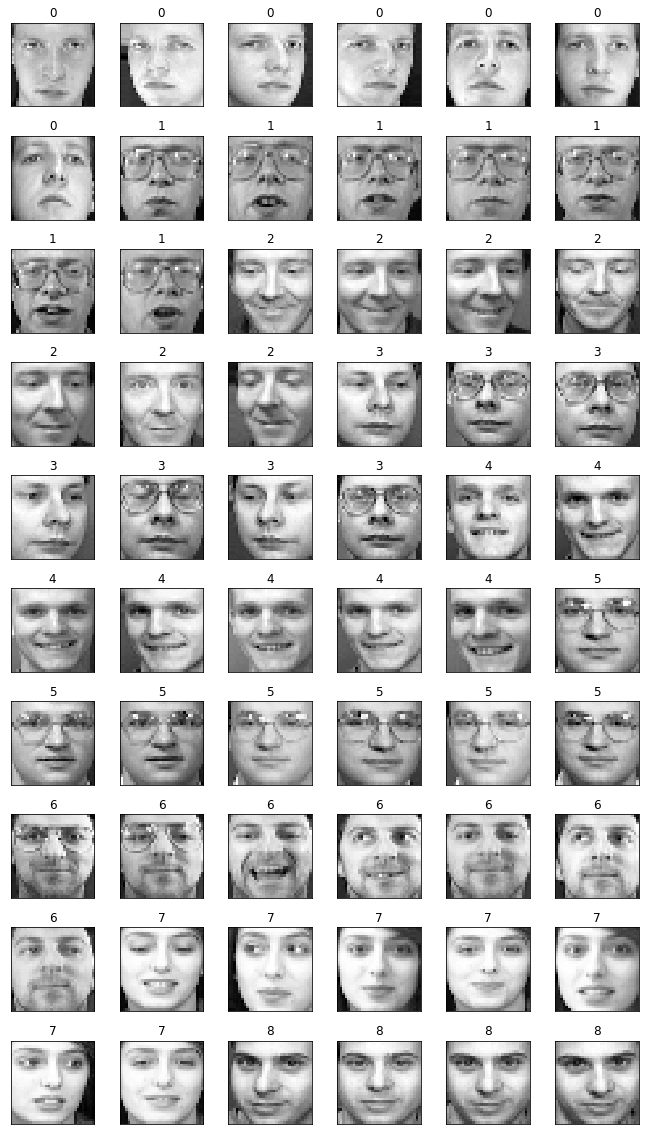

In [6]:
titles = [str(y) for y in y_train]

plot_gallery(X_train, titles, image_h, image_w, n_row=10)

## Привыкаем к пространствам большой размерности

Точка/вектор (это два эквивалентных термина) в N-мерном пространстве - это набор из N чисел. Так (1, 2, 0.3, -4, 0) - это вектор пятимерного пространства.

Расстояние между точками X и Y равно $\sqrt{\sum_i (x_i - y_i)^2}$.

Легко заметить, что в двухмерном случае мы получаем знакомую вам из геометрии точку и расстояние между точками. Вектора можно поэлементно складывать и вычитать -- точно так же как в двухмерном случае. Если вы изучаете какой-то алгоритм аппелирующий к геометрии, то можете представлять себе все происходящее в 2-х/3-х мерном случае, а потом говорить "в N-мерном случае всё будет аналогично". Все так делают.

## К ближайших соседей (K nearest neighbors)

Идея алгоритмов "ближайших соседей" проста - если понятие расстояния между примерами введено достаточно удачно (это может быть евклидово расстнояние между точками, определенное выше, угол между векторами, итд), то близкие в смысле этого расстояния примеры чаще лежат в одном классе, чем в разных. Классификация каждого объекта происходит следующим образом:

1) Вычисляется расстояние до каждого из объектов обучающей выборки

2) Отобраются k объектов обучающей выборки, расстояние до которых минимально

3) Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди k ближайших соседей

Например, объект на рисунке ниже будет отнесен к оранжевому классу.

<img src="files/screenshot.gif">

Посмотрим на результат применения KNN к искуственно сгенерированной выборке.

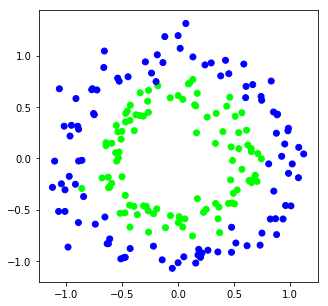

In [7]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=200, noise=0.1, factor=0.6)

plt.figure(figsize=(5, 5))
plt.scatter(*X.T, c=y, cmap=plt.cm.brg)
plt.show()

Мы воспользуемся готовой реализацией классификатора KNN из библиотеки sklearn, которая содержит множество различных алгоритмов машинного обучения и метрик.

Mean accuracy:  0.99


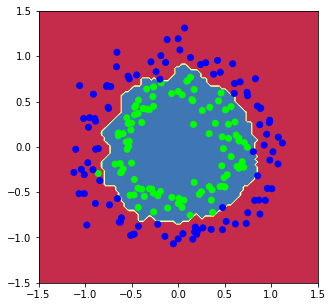

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

print('Mean accuracy: ', knn.score(X, y)) # accuracy - это процент правильно классифицированных объектов.

xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(5, 5))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.scatter(*X.T, c=y, cmap=plt.cm.brg)
plt.show()

### Вопрос: даст ли логистическая регрессия в режиме one vs rest хороший результат на сгенерированных выше данных? Почему?

*Ответ:* Да. Здесь можно найти зависимость и провести линию, разделяющую объекты разных классов.

### Вопрос: в каких случаях KNN будет работать плохо?

*Ответ:* При большом количестве объектов и высокой размерности.

____________________________________________________________________________________________________________

### Применим KNN к нашей задаче

В данной задаче объектами будут лица, а их признаками - вектор пикселей. Будем использовать обычную евклидову метрику: расстояние между изображениями $X$ и $Y$ равно $\sqrt{\sum_{i,j} (X_{i,j}-Y_{i,j})^2}$.

Обучите KNN с дефолтными параметрами и посчитайте процент правильно распознанных лиц на тестовой выборке.

In [9]:
from skimage.transform import resize

In [10]:
#for i in range (X_train.shape[0]):
X_train_new = resize(X_train, (280, 64,64))
X_test_new = resize(X_test, (120, 64,64))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [11]:
X_train_matrix_r = X_train_new.reshape((-1, 64 * 64))
X_test_matrix_r = X_test_new.reshape((-1, 64 * 64))

def resized_guess(x):

    # Ваш код здесь
    knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, n_neighbors=1, p=x, weights='uniform')
    knn.fit(X_train_matrix_r, y_train)
    test_score = knn.score(X_test_matrix_r, y_test)

    return test_score

In [12]:
X_train_matrix = X_train.reshape((-1, image_h * image_w))
X_test_matrix = X_test.reshape((-1, image_h * image_w))

def standart_guess(x):

    # Ваш код здесь
    knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, n_neighbors=1, p=x, weights='uniform')
    knn.fit(X_train_matrix, y_train)
    test_score = knn.score(X_test_matrix, y_test)

    return test_score

Поэкспериментируйте и опишите свои результаты. 
Идеи для дальнейших экспериментов:

1) Попробуйте найти оптимальный параметр количества ближайших соседей.

2) Посмотрите вляет ли разрешение изображения на качество классификации. Для изменения разрешения изображения можно воспользоваться функцией scipy.misc.imresize.

3*) Проведите те же самые эксперименты для логистической регрессии. Работает ли это лучше/хуже KNN? Почему?

In [13]:
# Ваш код здесь
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [14]:
def logit_guess(x):
    logit = LogisticRegression(C=x)
    logit.fit(X_train_matrix, y_train)

    return logit.score(X_test_matrix, y_test)

### Отчет:


Я решил построить график точности определения для изображений 32х32 и 64х64.
Пришёл к выводу, что разрешение изображения влияет сильно, а оптимальное количество ближайших соседей 1-3.

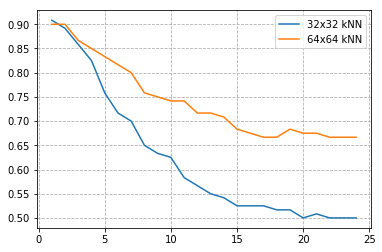

In [15]:
x = np.arange(1, 25, 1)

y1 = np.arange(1., 25, 1)
for i in range(1, 25):
    y1[i-1] = standart_guess(i)
    
y2 = np.arange(1., 25, 1)
for i in range(1, 25):
    y2[i-1] = resized_guess(i)

plt.figure()
plt.grid(ls='--')
plt.plot(x, y1, label='32x32 kNN')
plt.plot(x, y2, label='64x64 kNN')
plt.legend()
plt.show()

In [23]:
print(standart_guess(1))
print(resized_guess(2))

0.908333333333
0.9


Затем я попробовал логистическую регрессию с параметром 1.
Это дало точность выше, чем при kNN:

In [29]:
logit_guess(1)

0.95833333333333337

После этого я попробовал что-то непонятное из https://habrahabr.ru/company/ods/blog/323890/#2-logisticheskaya-regressiya и обнаружил, что это дало точность ниже, что я не понимаю что тут происходит, и что до дедлайна 15 часов.

In [16]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_train_matrix, y_train)


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.2min finished


LogisticRegressionCV(Cs=array([  1.00000e-02,   1.02334e-02, ...,   9.77192e+02,   1.00000e+03]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=1)

In [22]:
logit_searcher.score(X_test_matrix, y_test)

0.94166666666666665